# Trial Completion Event Study

Visualize stock price movement around clinical trial completion dates.

Enter a sponsor name below and run the cells to fetch fresh data, or leave blank to load the most recent analysis.

In [1]:
# Enter sponsor name to run fresh analysis (leave empty to load most recent)
SPONSOR_NAME = "AstraZeneca"  # e.g. "AstraZeneca", "Celldex Therapeutics", "Eli Lilly and Company"

In [2]:
import json
import os
import sys
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt

# Add parent dir to path for imports
sys.path.insert(0, str(Path('.').resolve().parent))

plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# Run fresh analysis or load existing data
output_dir = Path('output')

if SPONSOR_NAME.strip():
    # Run fresh analysis for the specified sponsor
    print(f'Running analysis for sponsor: {SPONSOR_NAME}')
    from trial_stock_impact import main as run_analysis
    df, metadata = run_analysis(SPONSOR_NAME.strip())
    
    ticker = metadata['ticker']
    event_date = metadata['event_date']
    trial = metadata.get('trial', {})
    print(f'\nLoaded fresh data for {ticker}')
else:
    # Load the most recent event study output
    parquet_files = sorted(output_dir.glob('*_event_study.parquet'))
    
    if not parquet_files:
        raise FileNotFoundError('No event study files found. Set SPONSOR_NAME or run trial_stock_impact.py first.')
    
    latest = parquet_files[-1]
    print(f'Loading cached: {latest.name}')
    
    # Parse ticker and date from filename
    parts = latest.stem.replace('_event_study', '').rsplit('_', 1)
    ticker, event_date = parts[0], parts[1]
    
    # Load data
    df = pl.read_parquet(latest)
    
    # Load metadata if available
    metadata_path = latest.with_name(latest.stem + '_metadata.json')
    metadata = {}
    if metadata_path.exists():
        with open(metadata_path) as f:
            metadata = json.load(f)
    
    trial = metadata.get('trial', {})

print(f'Ticker: {ticker} ({metadata.get("company_name", "N/A")})')
print(f'Event Date: {event_date}')

Running analysis for sponsor: AstraZeneca
[athena] Query started: 40ae3503-eea6-4939-a406-589dd75965c3
[athena] Found: AZN - AstraZeneca PLC
[athena] Trial: NCT06103877 completed 2026-01-13
[ctgov] Fetching trial details for NCT06103877
[ctgov] Phase: PHASE1, Enrollment: 108, Has Results: False
[massive] Fetching AZN OHLC: 2025-12-14 to 2026-02-12
[massive] Got 33 bars

TRIAL COMPLETION EVENT STUDY: AZN
Trial: NCT06103877 - A Placebo-controlled Safety and Tolerability Study...
Phase: PHASE1 | Enrollment: 108 | Conditions: Healthy Volunteers
Completion Date: 2026-01-13

Pre-event return (T-30 to T-1): -0.93%
Post-event return (T to T+30): 99.35%
Event day close: $94.51

[output] Saved to analysis/output/AZN_2026-01-13_event_study.parquet
[output] Saved to analysis/output/AZN_2026-01-13_event_study_metadata.json

Loaded fresh data for AZN
Ticker: AZN (AstraZeneca PLC)
Event Date: 2026-01-13


In [4]:
# Trial Details
if trial:
    print('=== Trial Details ===')
    print(f"NCT ID:       {trial.get('nct_id', 'N/A')}")
    print(f"Phase:        {trial.get('phase', 'N/A')}")
    print(f"Enrollment:   {trial.get('enrollment_count', 'N/A')} ({trial.get('enrollment_type', '')})")
    print(f"Study Type:   {trial.get('study_type', 'N/A')}")
    print(f"Conditions:   {', '.join(trial.get('conditions', []))}")
    print(f"Has Results:  {trial.get('has_results', False)}")
    print(f"\nTitle: {trial.get('brief_title', 'N/A')}")
else:
    print('No trial metadata available - run with SPONSOR_NAME to fetch')

=== Trial Details ===
NCT ID:       NCT06103877
Phase:        PHASE1
Enrollment:   108 (ACTUAL)
Study Type:   INTERVENTIONAL
Conditions:   Healthy Volunteers
Has Results:  False

Title: A Placebo-controlled Safety and Tolerability Study of Intravenous (IV) and Subcutaneous (SC) AZD1163 in Healthy Volunteers


In [5]:
# Preview price data
df.head(10)

date,o,h,l,c,v,vw,daily_return_pct,days_from_event,cumulative_return_pct
datetime[ms],f64,f64,f64,f64,f64,f64,f64,i64,f64
2025-12-15 05:00:00,90.37,91.79,90.12,91.56,7.020702e6,91.2299,null,-29,-3.121363
2025-12-16 05:00:00,90.87,91.575,90.1901,91.35,4.514854e6,90.905,-0.229358,-28,-3.343562
2025-12-17 05:00:00,91.09,91.25,89.85,89.86,5.975458e6,90.4123,-1.631089,-27,-4.920114
2025-12-18 05:00:00,90.285,91.17,90.19,90.61,6.82855e6,90.6868,0.834632,-26,-4.126547
2025-12-19 05:00:00,90.43,91.8699,90.36,91.36,8.374375e6,91.2823,0.827723,-25,-3.332981
2025-12-22 05:00:00,90.81,91.855,90.63,91.55,4.648995e6,91.5071,0.207968,-22,-3.131944
2025-12-23 05:00:00,92.515,93.1,91.941,92.14,3.544381e6,92.2943,0.644457,-21,-2.507671
2025-12-24 05:00:00,92.32,92.61,92.01,92.45,1.184654e6,92.4223,0.336445,-20,-2.179664
2025-12-26 05:00:00,92.525,92.91,92.18,92.9,1.669376e6,92.7064,0.48675,-18,-1.703523


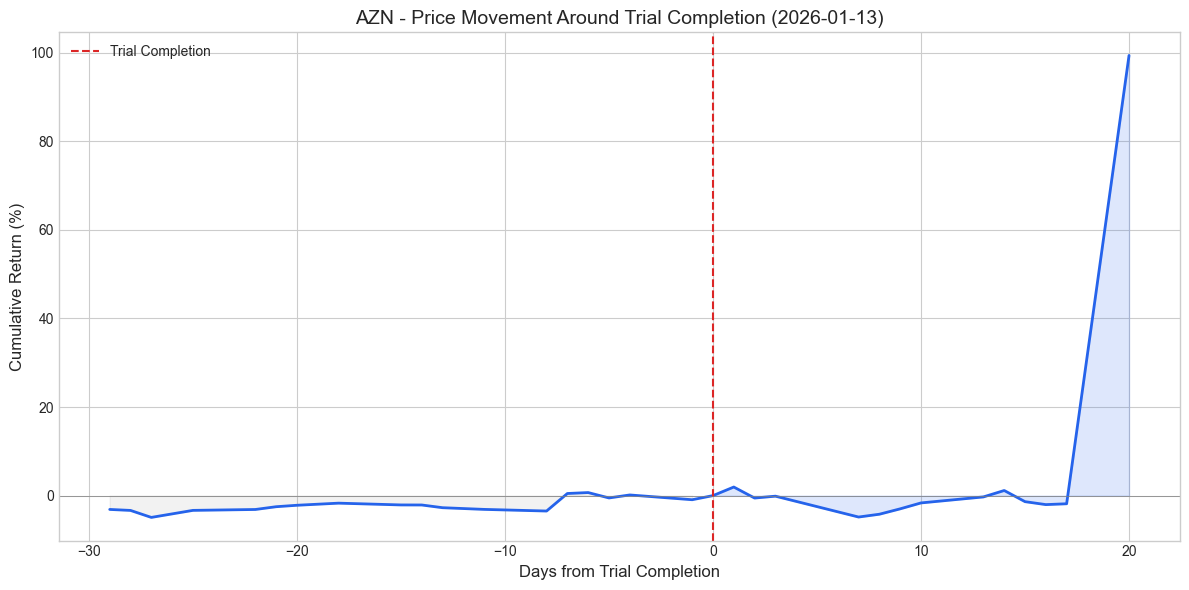

In [6]:
# Cumulative return plot around event
fig, ax = plt.subplots(figsize=(12, 6))

days = df['days_from_event'].to_list()
cum_ret = df['cumulative_return_pct'].to_list()

ax.plot(days, cum_ret, linewidth=2, color='#2563eb')
ax.axvline(x=0, color='#dc2626', linestyle='--', linewidth=1.5, label='Trial Completion')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

ax.fill_between(days, cum_ret, 0, where=[d >= 0 for d in days], alpha=0.15, color='#2563eb')
ax.fill_between(days, cum_ret, 0, where=[d < 0 for d in days], alpha=0.1, color='gray')

ax.set_xlabel('Days from Trial Completion', fontsize=12)
ax.set_ylabel('Cumulative Return (%)', fontsize=12)
ax.set_title(f'{ticker} - Price Movement Around Trial Completion ({event_date})', fontsize=14)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [7]:
# Summary statistics
pre_event = df.filter(pl.col('days_from_event') < 0)
post_event = df.filter(pl.col('days_from_event') >= 0)

print('=== Event Study Summary ===')
print(f'Ticker: {ticker}')
print(f'Event Date: {event_date}')
print(f'Data Range: {df["date"].min()} to {df["date"].max()}')
print()

if not pre_event.is_empty():
    print(f'Pre-event window: {len(pre_event)} trading days')
    print(f'  Cumulative return: {pre_event["cumulative_return_pct"][-1]:.2f}%')
    print(f'  Avg daily return: {pre_event["daily_return_pct"].mean():.3f}%')
    print(f'  Volatility (std): {pre_event["daily_return_pct"].std():.3f}%')
print()

if not post_event.is_empty():
    print(f'Post-event window: {len(post_event)} trading days')
    print(f'  Cumulative return: {post_event["cumulative_return_pct"][-1]:.2f}%')
    print(f'  Avg daily return: {post_event["daily_return_pct"].mean():.3f}%')
    print(f'  Volatility (std): {post_event["daily_return_pct"].std():.3f}%')

=== Event Study Summary ===
Ticker: AZN
Event Date: 2026-01-13
Data Range: 2025-12-15 05:00:00 to 2026-02-02 05:00:00

Pre-event window: 19 trading days
  Cumulative return: -0.93%
  Avg daily return: 0.131%
  Volatility (std): 1.222%

Post-event window: 14 trading days
  Cumulative return: 99.35%
  Avg daily return: 7.315%
  Volatility (std): 27.633%


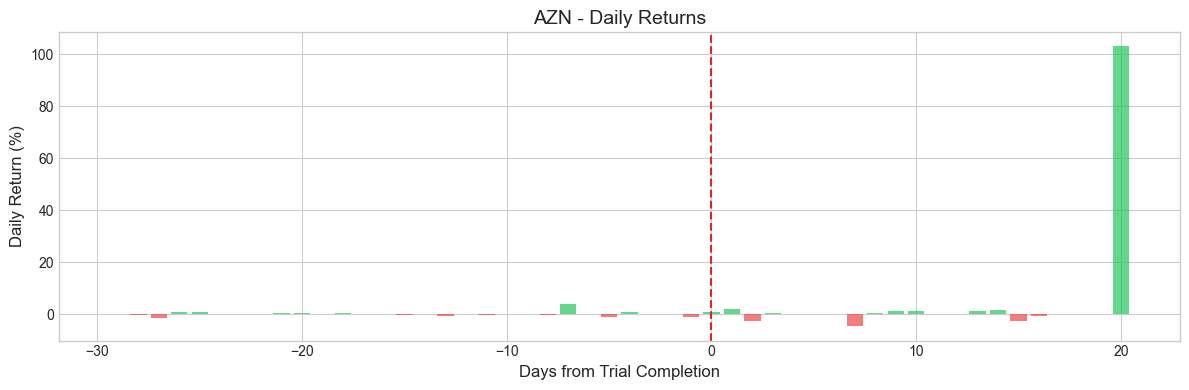

In [8]:
# Daily returns bar chart
fig, ax = plt.subplots(figsize=(12, 4))

# Handle None values from shift calculation
daily_returns = df['daily_return_pct'].fill_null(0).to_list()
colors = ['#22c55e' if r > 0 else '#ef4444' for r in daily_returns]
ax.bar(days, daily_returns, color=colors, alpha=0.7, width=0.8)
ax.axvline(x=0, color='#dc2626', linestyle='--', linewidth=1.5)

ax.set_xlabel('Days from Trial Completion', fontsize=12)
ax.set_ylabel('Daily Return (%)', fontsize=12)
ax.set_title(f'{ticker} - Daily Returns', fontsize=14)

plt.tight_layout()
plt.show()